In [1]:
pip install pycm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
# %matplotlib inline

from numpy.random import seed
# from tensorflow import set_random_seed
import tensorflow as tf
# tf.logging.set_verbosity(tf.logging.ERROR)


from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
import os
# os.chdir('C:/Lehigh/Rick- Anomaly Detection/Code')

In [4]:
df1 = pd.read_csv('/content/drive/MyDrive/Rick- Anomaly Detection/Data/Yang/Matrix_sensor_path5_v1.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Rick- Anomaly Detection/Data/Yang/Matrix_sensor_path5_v2.csv')
df1 = df1.drop(columns=['Unnamed: 0'])
df2 = df2.drop(columns=['Unnamed: 0'])

<function matplotlib.pyplot.show(close=None, block=None)>

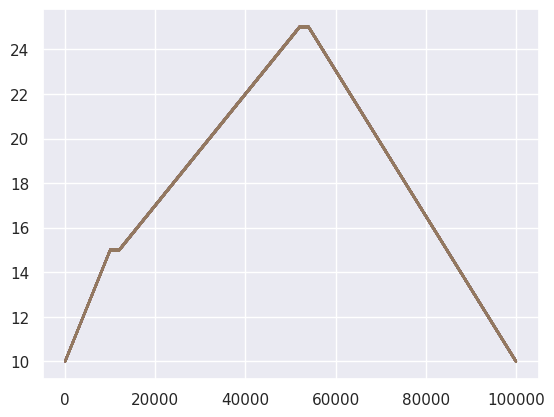

In [5]:

plt.plot(range(len(df1['protected_sensor'])), df1['protected_sensor'])
plt.plot(range(len(df1['sensor1'])), df1['sensor1'])
plt.plot(range(len(df1['sensor2'])), df1['sensor2'])
plt.plot(range(len(df1['sensor3'])), df1['sensor3'])
plt.plot(range(len(df1['sensor4'])), df1['sensor4'])
plt.plot(range(len(df1['sensor5'])), df1['sensor5'])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

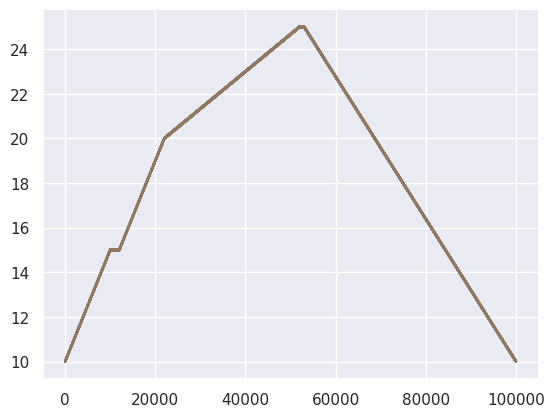

In [6]:

plt.plot(range(len(df2['protected_sensor2'])), df2['protected_sensor2'])
plt.plot(range(len(df2['sensor2_1'])), df2['sensor2_1'])
plt.plot(range(len(df2['sensor2_2'])), df2['sensor2_2'])
plt.plot(range(len(df2['sensor2_3'])), df2['sensor2_3'])
plt.plot(range(len(df2['sensor2_4'])), df2['sensor2_4'])
plt.plot(range(len(df2['sensor2_5'])), df2['sensor2_5'])
plt.show

In [34]:
from sklearn.model_selection import train_test_split
train = df1
test = df2
# train, test = train_test_split(df, test_size = 0.2, shuffle = False)

In [35]:
test.head()

,protected_sensor2,sensor2_1,sensor2_2,sensor2_3,sensor2_4,sensor2_5
0,9.989763,10.003115,10.003452,10.007273,9.988044,9.998783
1,10.006256,9.996641,9.993156,10.014655,9.994584,9.996212
2,9.998943,10.007696,10.020955,9.985223,10.006493,9.979732
3,10.016738,10.001262,9.985183,9.996511,9.990933,10.009697
4,10.003835,10.011487,9.993151,10.003441,10.004385,10.010990


In [36]:

print(train.shape, test.shape)

(100000, 6) (100000, 6)


In [37]:
test.columns = train.columns

In [38]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(df1)
X_train = scaler.transform(train)
X_test = scaler.transform(test)

In [39]:
test

,protected_sensor,sensor1,sensor2,sensor3,sensor4,sensor5
0,9.989763,10.003115,10.003452,10.007273,9.988044,9.998783
1,10.006256,9.996641,9.993156,10.014655,9.994584,9.996212
2,9.998943,10.007696,10.020955,9.985223,10.006493,9.979732
3,10.016738,10.001262,9.985183,9.996511,9.990933,10.009697
4,10.003835,10.011487,9.993151,10.003441,10.004385,10.010990
...,...,...,...,...,...,...
99995,9.997566,10.006207,9.997450,9.997189,10.004224,9.992263
99996,10.004256,9.977817,9.996812,9.991952,9.989195,10.009038
99997,9.981628,9.997977,10.015610,9.996046,10.009104,10.001742
99998,9.993879,10.005367,10.001724,9.987606,9.996630,10.002157


In [40]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (100000, 1, 6)
Test data shape: (100000, 1, 6)


In [15]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [16]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 6)]            0         
                                                                 
 lstm (LSTM)                 (None, 1, 16)             1472      
                                                                 
 lstm_1 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector (RepeatVector  (None, 1, 4)             0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 1, 4)              144       
                                                                 
 lstm_3 (LSTM)               (None, 1, 16)             1344      
                                                             

In [ ]:
nb_epochs = 10
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.1).history

Epoch 1/10
9000/9000 [==============================] - 55s 6ms/step - loss: 0.0160 - val_loss: 2.1246e-05
Epoch 2/10
9000/9000 [==============================] - 53s 6ms/step - loss: 1.5728e-05 - val_loss: 4.4774e-04
Epoch 3/10
9000/9000 [==============================] - 53s 6ms/step - loss: 1.5524e-05 - val_loss: 8.4612e-06
Epoch 4/10
5779/9000 [==================>...........] - ETA: 17s - loss: 1.2298e-05

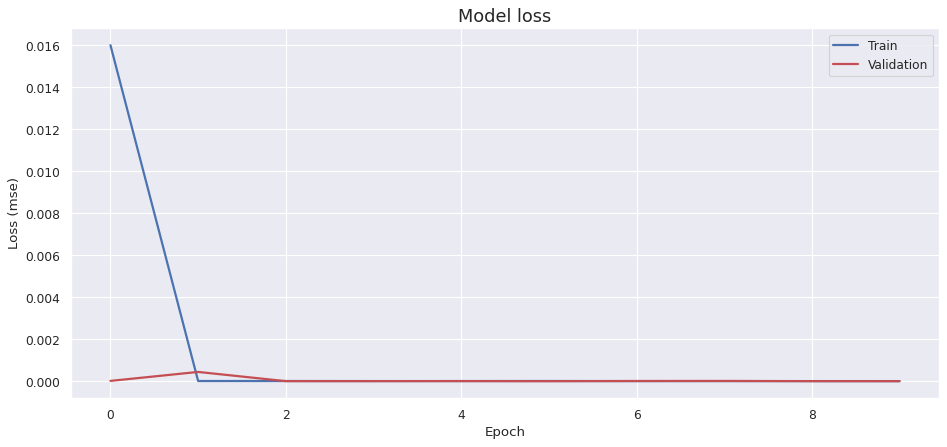

In [18]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mse)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [19]:
X_train

array([[[-1.9053881 , -1.90593395, -1.90485922, -1.90518626,
         -1.90482035, -1.90479995]],

       [[-1.90660603, -1.90533857, -1.90286902, -1.90739389,
         -1.90868231, -1.90301754]],

       [[-1.90695056, -1.90595895, -1.90723663, -1.90585093,
         -1.90487723, -1.9073075 ]],

       ...,

       [[-1.90573973, -1.90215706, -1.90641279, -1.90636819,
         -1.90728587, -1.90559968]],

       [[-1.90829059, -1.90914069, -1.90565049, -1.90201841,
         -1.90617603, -1.90367042]],

       [[-1.90884184, -1.90759214, -1.90715415, -1.90791078,
         -1.90506054, -1.90514947]]])

In [20]:
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index
scored = pd.DataFrame(index=train.index)
scored

3125/3125 [==============================] - 18s 5ms/step


""
0
1
2
3
4
...
99995
99996
99997
99998


3125/3125 [==============================] - 8s 3ms/step


<ipython-input-21-1e7a245e34f2>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Loss_mse, bins=50, kde= True)


<Axes: ylabel='Density'>

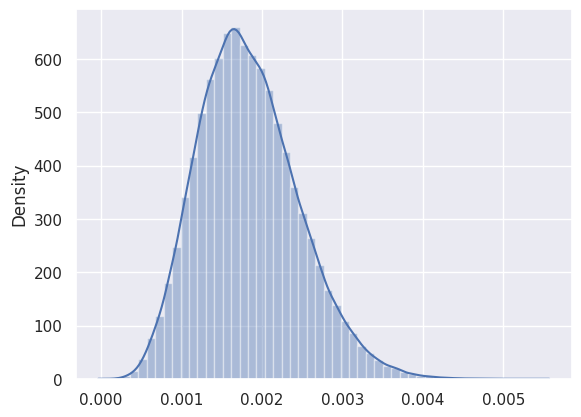

In [21]:
import seaborn as sns
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
Loss_mse = np.mean(np.abs(X_pred-Xtrain), axis = 1)

sns.distplot(Loss_mse, bins=50, kde= True)

In [22]:
threshold = np.percentile(Loss_mse, 99)

In [41]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mse'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
# scored['Threshold'] = threshold
# scored['Anomaly'] = scored['Loss_mse'] > scored['Threshold']
# scored.head()

3125/3125 [==============================] - 9s 3ms/step


In [24]:
pd.DataFrame(Xtrain, columns=test.columns)

,protected_sensor,sensor1,sensor2,sensor3,sensor4,sensor5
0,-1.905388,-1.905934,-1.904859,-1.905186,-1.904820,-1.904800
1,-1.906606,-1.905339,-1.902869,-1.907394,-1.908682,-1.903018
2,-1.906951,-1.905959,-1.907237,-1.905851,-1.904877,-1.907307
3,-1.905480,-1.901143,-1.907667,-1.911675,-1.908956,-1.906143
4,-1.906923,-1.902062,-1.903730,-1.906263,-1.906308,-1.904167
...,...,...,...,...,...,...
99995,-1.905566,-1.904359,-1.906610,-1.904329,-1.908112,-1.906468
99996,-1.905708,-1.907078,-1.908955,-1.906828,-1.906173,-1.908145
99997,-1.905740,-1.902157,-1.906413,-1.906368,-1.907286,-1.905600
99998,-1.908291,-1.909141,-1.905650,-1.902018,-1.906176,-1.903670


In [42]:
pd.DataFrame(Xtest, columns=test.columns)

,protected_sensor,sensor1,sensor2,sensor3,sensor4,sensor5
0,-1.908584,-1.905406,-1.905362,-1.904458,-1.908947,-1.906459
1,-1.904703,-1.906930,-1.907785,-1.902721,-1.907408,-1.907064
2,-1.906424,-1.904328,-1.901243,-1.909647,-1.904605,-1.910942
3,-1.902236,-1.905842,-1.909662,-1.906991,-1.908267,-1.903890
4,-1.905273,-1.903436,-1.907787,-1.905359,-1.905101,-1.903586
...,...,...,...,...,...,...
99995,-1.906748,-1.904679,-1.906775,-1.906831,-1.905139,-1.907993
99996,-1.905174,-1.911360,-1.906925,-1.908063,-1.908676,-1.904045
99997,-1.910499,-1.906615,-1.902501,-1.907100,-1.903991,-1.905762
99998,-1.907616,-1.904876,-1.905769,-1.909086,-1.906926,-1.905664


In [63]:
pd.DataFrame(Xtest, columns=test.columns)['sensor1']

0       -1.949546
1       -1.952857
2       -1.949098
3       -1.949806
4       -1.952243
           ...   
99995   -1.950738
99996   -1.948985
99997   -1.948263
99998   -1.948177
99999   -1.948658
Name: sensor1, Length: 100000, dtype: float64

0       -1.949546
1       -1.952857
2       -1.949098
3       -1.949806
4       -1.952243
           ...   
99995   -1.950738
99996   -1.948985
99997   -1.948263
99998   -1.948177
99999   -1.948658
Name: sensor1, Length: 100000, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

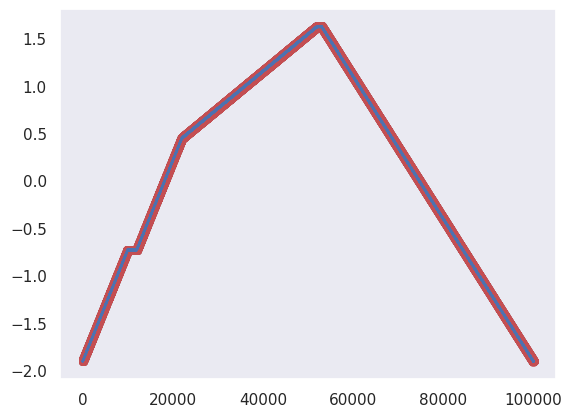

In [43]:
import matplotlib.pyplot as plt

plt.plot(range(len(pd.DataFrame(Xtest, columns=test.columns)['sensor1'])), pd.DataFrame(Xtest, columns=test.columns)['sensor1'])
plt.scatter(range(len(X_pred['sensor1'])), X_pred['sensor1'], c = 'r', linewidths = 0.3)
plt.grid(False)
# plt.axes.set_facecolor(color=None)
plt.show

In [ ]:
# plot bearing failure time plot
# scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])